In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from random import shuffle
import random
import math

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def efficient_frontier(returns, n_samples=50, gamma_low=-1, gamma_high=10):
    """
    construye un conjunto de problemas de programación cuádrática
    para inferir la frontera eficiente de Markovitz. 
    En cada problema el parámetro gamma se cambia para aumentar
    la penalización del riesgo en la función de maximización.
    """
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values  
    n = sigma.shape[0]        
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)
    
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                      [cp.sum(w) == 1,  w >= 0]) 
    # Equivalente 
    #prob = cp.Problem(cp.Minimize(risk - gamma*ret), 
    #                  [cp.sum(w) == 1,  w >= 0])   
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)
    
    portfolio_weights = []    
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)   
    return ret_data, risk_data, gamma_vals, portfolio_weights


def optimal_portfolio(returns):
    """
    A partir del calculo de la frontera eficiente de Markowitz
    devuelve el portfolio optimo: su ratio de sharpe, rentabilidad,
    riesgo y pesos.
    """
    ret_data, risk_data, _, portfolio_weights = efficient_frontier(returns)

    sharpes = ret_data/risk_data 
    idx = np.argmax(sharpes)
    optimal_ret, optimal_risk = ret_data[idx], risk_data[idx]
    optimal_portfolio = pd.Series(portfolio_weights[idx],
                                index=returns.columns).abs().round(3)

    optimal_portfolio = optimal_portfolio.div(optimal_portfolio.sum()).round(3)
                                
    return sharpes[idx], optimal_ret, optimal_risk, optimal_portfolio

In [3]:
funds = pd.read_csv('funds.csv', index_col=0, parse_dates=[0])
funds

,AT0000494893,AT0000495189,AT0000495197,AT0000495304,AT0000497268,AT0000497284,AT0000499785,AT0000506050,AT0000506068,AT0000607254,...,US9229086296,US9229086379,US9229086528,US9229087369,US9229087443,US9229087518,US9229087690,US97717W4226,US97717X5941,VGG4157S1048
2020-01-03,240.95,8.55,11.23,170.99,283.58,2.60,13.79,9.31,11.86,135.74,...,141.33,126.08,94.95,166.17,95.32,121.33,136.90,18.0118,33.48,1122.29
2020-01-06,240.95,8.55,11.23,170.99,283.58,2.60,13.79,9.31,11.86,135.74,...,141.33,126.08,94.95,166.17,95.32,121.33,136.90,18.0118,33.48,1120.12
2020-01-07,230.73,8.55,11.23,169.50,280.11,2.60,13.62,9.31,11.86,136.39,...,141.33,126.08,94.95,166.17,95.32,121.33,136.90,18.0118,33.48,1122.76
2020-01-08,234.45,8.55,11.23,169.69,282.22,2.60,13.71,9.31,11.86,136.22,...,141.33,126.08,94.95,166.17,95.32,121.33,136.90,18.0118,33.48,1123.03
2020-01-09,237.00,8.55,11.23,169.60,282.27,2.60,13.72,9.31,11.86,136.02,...,141.33,126.08,94.95,166.17,95.32,121.33,136.90,18.0118,33.48,1127.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07,185.34,9.08,11.92,149.72,292.03,3.22,12.19,10.35,13.18,140.82,...,204.36,173.28,159.53,247.93,118.41,187.99,191.26,27.9554,33.48,1167.13
2020-12-08,185.34,9.08,11.92,149.72,292.03,3.22,12.19,10.35,13.18,140.82,...,205.28,173.84,161.08,248.55,118.90,189.63,192.04,28.0735,33.48,1167.71
2020-12-09,186.89,9.09,11.94,149.32,293.39,3.19,12.19,10.37,13.20,141.54,...,203.21,172.16,158.56,244.11,118.97,188.51,190.27,28.2213,33.48,1169.33
2020-12-10,188.30,9.10,11.95,150.02,294.73,3.23,12.25,10.37,13.21,141.54,...,203.21,172.16,158.56,244.11,118.97,188.51,190.27,28.2213,33.48,1165.63


In [4]:
returns = np.log(funds).diff().dropna()
returns

,AT0000494893,AT0000495189,AT0000495197,AT0000495304,AT0000497268,AT0000497284,AT0000499785,AT0000506050,AT0000506068,AT0000607254,...,US9229086296,US9229086379,US9229086528,US9229087369,US9229087443,US9229087518,US9229087690,US97717W4226,US97717X5941,VGG4157S1048
2020-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001935
2020-01-07,-0.043341,0.000000,0.000000,-0.008752,-0.012312,0.000000,-0.012404,0.000000,0.000000,0.004777,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002354
2020-01-08,0.015994,0.000000,0.000000,0.001120,0.007505,0.000000,0.006586,0.000000,0.000000,-0.001247,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000240
2020-01-09,0.010818,0.000000,0.000000,-0.000531,0.000177,0.000000,0.000729,0.000000,0.000000,-0.001469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003609
2020-01-10,0.060257,0.000000,0.000000,0.000118,0.017315,0.000000,0.006538,0.000000,0.000000,-0.001913,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07,-0.003393,0.001102,0.000839,0.006500,0.010499,0.012500,0.004110,0.003872,0.003801,-0.000994,...,-0.001907,-0.000635,0.003642,0.003839,-0.006314,-0.002815,-0.000888,0.008698,0.0,0.000060
2020-12-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004492,0.003227,0.009669,0.002498,0.004130,0.008686,0.004070,0.004216,0.0,0.000497
2020-12-09,0.008328,0.001101,0.001676,-0.002675,0.004646,-0.009360,0.000000,0.001931,0.001516,0.005100,...,-0.010135,-0.009711,-0.015768,-0.018025,0.000589,-0.005924,-0.009260,0.005251,0.0,0.001386
2020-12-10,0.007516,0.001100,0.000837,0.004677,0.004557,0.012461,0.004910,0.000000,0.000757,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.003169


In [5]:
def nueva_generacion_variado_inverso(cromo_max_sharpe, list_info_cromo):
    """
    Creación de nueva generacion.

    Obtencion de padres: el primero por ruleta y el segundo por 
    emparejamiento variado inverso. 2 padres generan 1 hijo.

    Mutacion del hijo, se incluye una probabilidad de mutacion y se 
    añaden entre 1 y 4 nuevos activos, escogidos aleatoriamente.
    
    Reemplazo total, la generación de hijos reemplaza a sus padres, 
    a excepción del mejor de la generación anterior.
    """

    list_info_hijos = []

    for crom in range(n_cromosomas - 1):
        # try:
        # Reordeno la lista de cromosomas aleatoriamente
        shuffle(list_info_cromo)
        # Obtengo una lista con probabilidades de seleccionar a un padre
        rand_probs = np.random.uniform(0, 1, size=len(list_info_cromo))
        # A los padres les asigno un 1 si se seleccionaron, 0 si no
        padres = [1 if rand_prob < list_info[0] else 0 for rand_prob, list_info in zip(rand_probs, list_info_cromo)]

        # Ahora voy a seleccionar los padres que sean 1
        new_padres = []
        [new_padres.append(list_info) if padre == 1 else '' for padre, list_info in zip(padres, list_info_cromo)]
        # Me quedo con el primer padre
        padres = new_padres[:1]

        # get random subset of list_info_cromo
        list_info_cromo_random = random.sample(list_info_cromo, random.randint(1, len(list_info_cromo)))

        # get minimum sharpe of list_info_cromo_random
        min_sharpe = min(list_info_cromo_random, key=lambda x: x[0])

        padres = padres + [min_sharpe]


        # cojo los activos con peso mayor que 0 de cada padre
        activos_padres = padres[1][4][padres[1][4] > 0].index.to_list() + padres[0][4][padres[0][4] > 0].index.to_list()
        # get unique elements from list
        activos_padres = list(set(activos_padres))

        shuffle(activos_padres)
        activos_padres = activos_padres[:min(len(activos_padres), random.randint(1,16))]

        # # Calculo correlaciones entre los activos de los padres
        # corr_padres = returns.loc[:, activos_padres].corr().dropna(axis=0, how='all').dropna(axis=1, how='all')
        # corr_padres = corr_padres[corr_padres != 1]
        # print(corr_padres)

        # Mutaciones
        activos_mutacion = returns.iloc[:, random.sample(range(0,n_genes), random.randint(0,4))].columns.to_list()
        activos_hijo = activos_padres + activos_mutacion
        activos_hijo = list(set(activos_hijo))


        # Hijo
        returns_hijo = returns.loc[:, activos_hijo]
    
        sharpe, ret, std, weights = optimal_portfolio(returns_hijo)
        list_info_hijos.append([sharpe, ret, std, weights])
        # print(len(weights), len(weights[weights > 0]))
        # except:
        #     pass


    # Añado el padre con mayor sharpe a la lista de hijos
    list_info_hijos.append(cromo_max_sharpe)

    return list_info_hijos

# ALGORTIMO GENETICO

 Generar aleatoriamente una población inicial

 Repetir hasta que se cumpla la condición de parad

     Evaluar los individuos según la función objetivo (maximizar beneficio, minimizar distancia)

     Seleccionar padres (en función de la evaluación anterior).
    
     Cruzamiento: recombinar material genético de los padres

     Evaluar si el individuo, o parte de su código genético muta

     Reemplazo generacional
    
     Generación = Generación +1

 Cuando se cumpla condición de parada, devolver mejor solución.

In [6]:
def evalua_cromosomas(list_info_cromo):
    """
    Evalua los cromosomas de una población.
    Normaliza sharpe para la seleccion de padres posterior, 
    y devuelve el cromosoma con mayor sharpe.
    Devuelve una lista de tuplas (max_sharpe, list_info_cromo)
    """
    # Lista con los sharpes
    sharpes = [item[0] for item in list_info_cromo]
    # Elimino sharpes infinitos
    sharpes = [np.nanmin(sharpes) if item == np.inf else item for item in sharpes]
    
    # Normalizo sharpe con el minimo y maximo
    norm_sharpes = ((sharpes - np.nanmin(sharpes))/(np.nanmax(sharpes) - np.nanmin(sharpes))).tolist()
    
    # Agrego la lista de norm_sharpes a la lista de cromosomas con el resto de info
    list_info_cromo = [[norm_sharpe, list_info[0], list_info[1], list_info[2], list_info[3]] for norm_sharpe, list_info in zip(norm_sharpes, list_info_cromo)]

    max_sharpe = []
    [max_sharpe.append(item) if item[0] == 1 else '' for item in list_info_cromo]
    max_sharpe = max_sharpe[0][1:]
        
    return max_sharpe, list_info_cromo


In [7]:
def nueva_generacion(cromo_max_sharpe, list_info_cromo):
    """
    Creación de nueva generacion.

    Obtencion de padres por ruleta, 2 padres generan 1 hijo.

    Mutacion del hijo, se incluye una probabilidad de mutacion y se 
    añaden entre 1 y 4 nuevos activos, escogidos aleatoriamente.
    
    Reemplazo total, la generación de hijos reemplaza a sus padres, 
    a excepción del mejor de la generación anterior.
    """

    list_info_hijos = []

    for crom in range(n_cromosomas - 1):
        try:
            # Reordeno la lista de cromosomas aleatoriamente
            shuffle(list_info_cromo)
            # Obtengo una lista con probabilidades de seleccionar a un padre
            rand_probs = np.random.uniform(0, 1, size=len(list_info_cromo))
            # A los padres les asigno un 1 si se seleccionaron, 0 si no
            padres = [1 if rand_prob < list_info[0] else 0 for rand_prob, list_info in zip(rand_probs, list_info_cromo)]

            # Ahora voy a seleccionar los padres que sean 1
            new_padres = []
            [new_padres.append(list_info) if padre == 1 else '' for padre, list_info in zip(padres, list_info_cromo)]
            # Me quedo con los 2 primeros padres
            padres = new_padres[:2]


            # cojo los activos con peso mayor que 0 de cada padre
            activos_padres = padres[1][4][padres[1][4] > 0].index.to_list() + padres[0][4][padres[0][4] > 0].index.to_list()
            # get unique elements from list
            activos_padres = list(set(activos_padres))

            shuffle(activos_padres)
            activos_padres = activos_padres[:min(len(activos_padres), random.randint(1,16))]

            # # Calculo correlaciones entre los activos de los padres
            # corr_padres = returns.loc[:, activos_padres].corr().dropna(axis=0, how='all').dropna(axis=1, how='all')
            # corr_padres = corr_padres[corr_padres != 1]
            # print(corr_padres)

            # Mutaciones
            activos_mutacion = returns.iloc[:, random.sample(range(0,n_genes), random.randint(0,4))].columns.to_list()
            activos_hijo = activos_padres + activos_mutacion
            activos_hijo = list(set(activos_hijo))


            # Hijo
            returns_hijo = returns.loc[:, activos_hijo]
        
            sharpe, ret, std, weights = optimal_portfolio(returns_hijo)
            list_info_hijos.append([sharpe, ret, std, weights])
            # print(len(weights), len(weights[weights > 0]))
        except:
            pass


    # Añado el padre con mayor sharpe a la lista de hijos
    list_info_hijos.append(cromo_max_sharpe)

    return list_info_hijos

### Generacion aleatoria inicial

In [8]:
# genes = activos
n_genes = returns.shape[1]

# cromosomas = inversores
n_cromosomas = round(n_genes * (50/(5+n_genes)))

n_cromosomas = 25

print(n_genes, n_cromosomas)

68151 25


In [9]:
# En la generacion aleatoria inicial introduzco una cartera que incluye el activo
# con mayor sharpe, y el 3 activos muy descorrelacionados con ese para partir de una cartera
# con sharpe elevado
df_sharpe = returns.mean()/returns.std()
best_sharpe = df_sharpe.sort_values(ascending=False).head(30).index[0]
corr_max_sharpes = returns.loc[:, df_sharpe.sort_values(ascending=False).head(200).index.tolist()].corr().loc[:, best_sharpe]
best_sharpe_descorr = corr_max_sharpes[corr_max_sharpes >= 0 ].sort_values(ascending=True).index.tolist()[:3]
best_sharpe_descorr.append(best_sharpe)

list_info_cromo = []

# Para cada cromosoma de la población inicial escogo aleatoriamente una cantidad de activos
# entre 1 y 20, y calculo la cartera que maximiza el sharpe. 
for i in range(0, n_cromosomas):
    if i == 0:
        returns_random = returns.loc[:, best_sharpe_descorr]
    else:
        returns_random = returns.iloc[:, random.sample(range(0,n_genes), random.randint(1,20))]
    sharpe, ret, std, weights = optimal_portfolio(returns_random)
    list_info_cromo.append([sharpe, ret, std, weights])

# Obtengo el cromosoma con mayor sharpe, y la lista de cromosomas con sharpe normalizado
max_sharpe, list_info_cromo = evalua_cromosomas(list_info_cromo)

print(f'Generacion 0 - sharpe {round(max_sharpe[0], 4)}')


# Lista de listas con los activos que componen la cartera de mejor sharpe de cada generacion,
# para luego poder sacar la evolucion de la frontera eficiente por generaciones
list_activos_mejor_frontera = []

list_activos_mejor_frontera.append(max_sharpe[3].index.to_list())

# Lista con los sharpes maximos de cada generacion, se usara para la condicion de parada
max_sharpes = []

max_sharpes.append(max_sharpe[0])

last_sharpe = 0.01
diff_sharpes = [0.01]

idx = 1

# Bucle de las sucesivas generaciones
while not all(i < 0.0001 for i in diff_sharpes[-30:]):
    lista_media_activos = []

    list_info_cromo = nueva_generacion_variado_inverso(max_sharpe, list_info_cromo)

    max_sharpe, list_info_cromo = evalua_cromosomas(list_info_cromo)

    [lista_media_activos.append(len(item[4].index.to_list())) for item in list_info_cromo]

    max_sharpes.append(max_sharpe[0])

    list_activos_mejor_frontera.append(max_sharpe[3].index.to_list())

    diff_sharpes.append((max_sharpe[0] - last_sharpe)/last_sharpe)

    last_sharpe = max_sharpe[0]

    print(f'Generacion {idx} - sharpe {round(max_sharpe[0], 4)} - activos {len(max_sharpe[3].index.to_list())} - media_activos {round(np.mean(lista_media_activos), 2)} - max_activos {max(lista_media_activos)} - min_activos {min(lista_media_activos)}')
    idx += 1
    # print(diff_sharpes[-30:], not all(i < 0.0001 for i in diff_sharpes[-30:]))


Generacion 0 - sharpe 1.4
Generacion 1 - sharpe 1.4026 - activos 7 - media_activos 6.6 - max_activos 10 - min_activos 1
Generacion 2 - sharpe 1.4173 - activos 14 - media_activos 7.64 - max_activos 15 - min_activos 2
Generacion 3 - sharpe 1.4173 - activos 14 - media_activos 7.96 - max_activos 15 - min_activos 3
Generacion 4 - sharpe 1.4173 - activos 14 - media_activos 7.16 - max_activos 14 - min_activos 2
Generacion 5 - sharpe 1.4404 - activos 9 - media_activos 7.56 - max_activos 14 - min_activos 1
Generacion 6 - sharpe 1.4404 - activos 7 - media_activos 7.12 - max_activos 12 - min_activos 4
Generacion 7 - sharpe 1.443 - activos 12 - media_activos 9.4 - max_activos 14 - min_activos 6
Generacion 8 - sharpe 1.541 - activos 15 - media_activos 8.36 - max_activos 15 - min_activos 1
Generacion 9 - sharpe 1.541 - activos 15 - media_activos 8.36 - max_activos 15 - min_activos 2
Generacion 10 - sharpe 1.541 - activos 15 - media_activos 8.0 - max_activos 15 - min_activos 2
Generacion 11 - sharpe 

In [ ]:
list_info_cromo

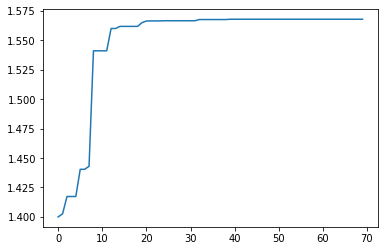

In [11]:
plt.plot(max_sharpes)

In [12]:
max_sharpe[3]

FR0013270436    0.0
FI4000390844    0.0
LU1598746482    0.0
SG9999001861    0.0
LU0049015760    0.0
IE00BK71DN90    0.0
IE0004514711    1.0
IE00BN2BS412    0.0
LU2229037341    0.0
LU0089639750    0.0
LU1273508686    0.0
SG9999019293    0.0
LU2145459348    0.0
LU1442549611    0.0
IE00BL5GSP02    0.0
LU0713369212    0.0
LU0096353940    0.0
IE00BD31MX79    0.0
LU1989786717    0.0
dtype: float64

In [13]:
max_sharpe[3][max_sharpe[3] > 0]

IE0004514711    1.0
dtype: float64

Text(0.5, 1.0, 'Eficient Frontier Max Sharpe')

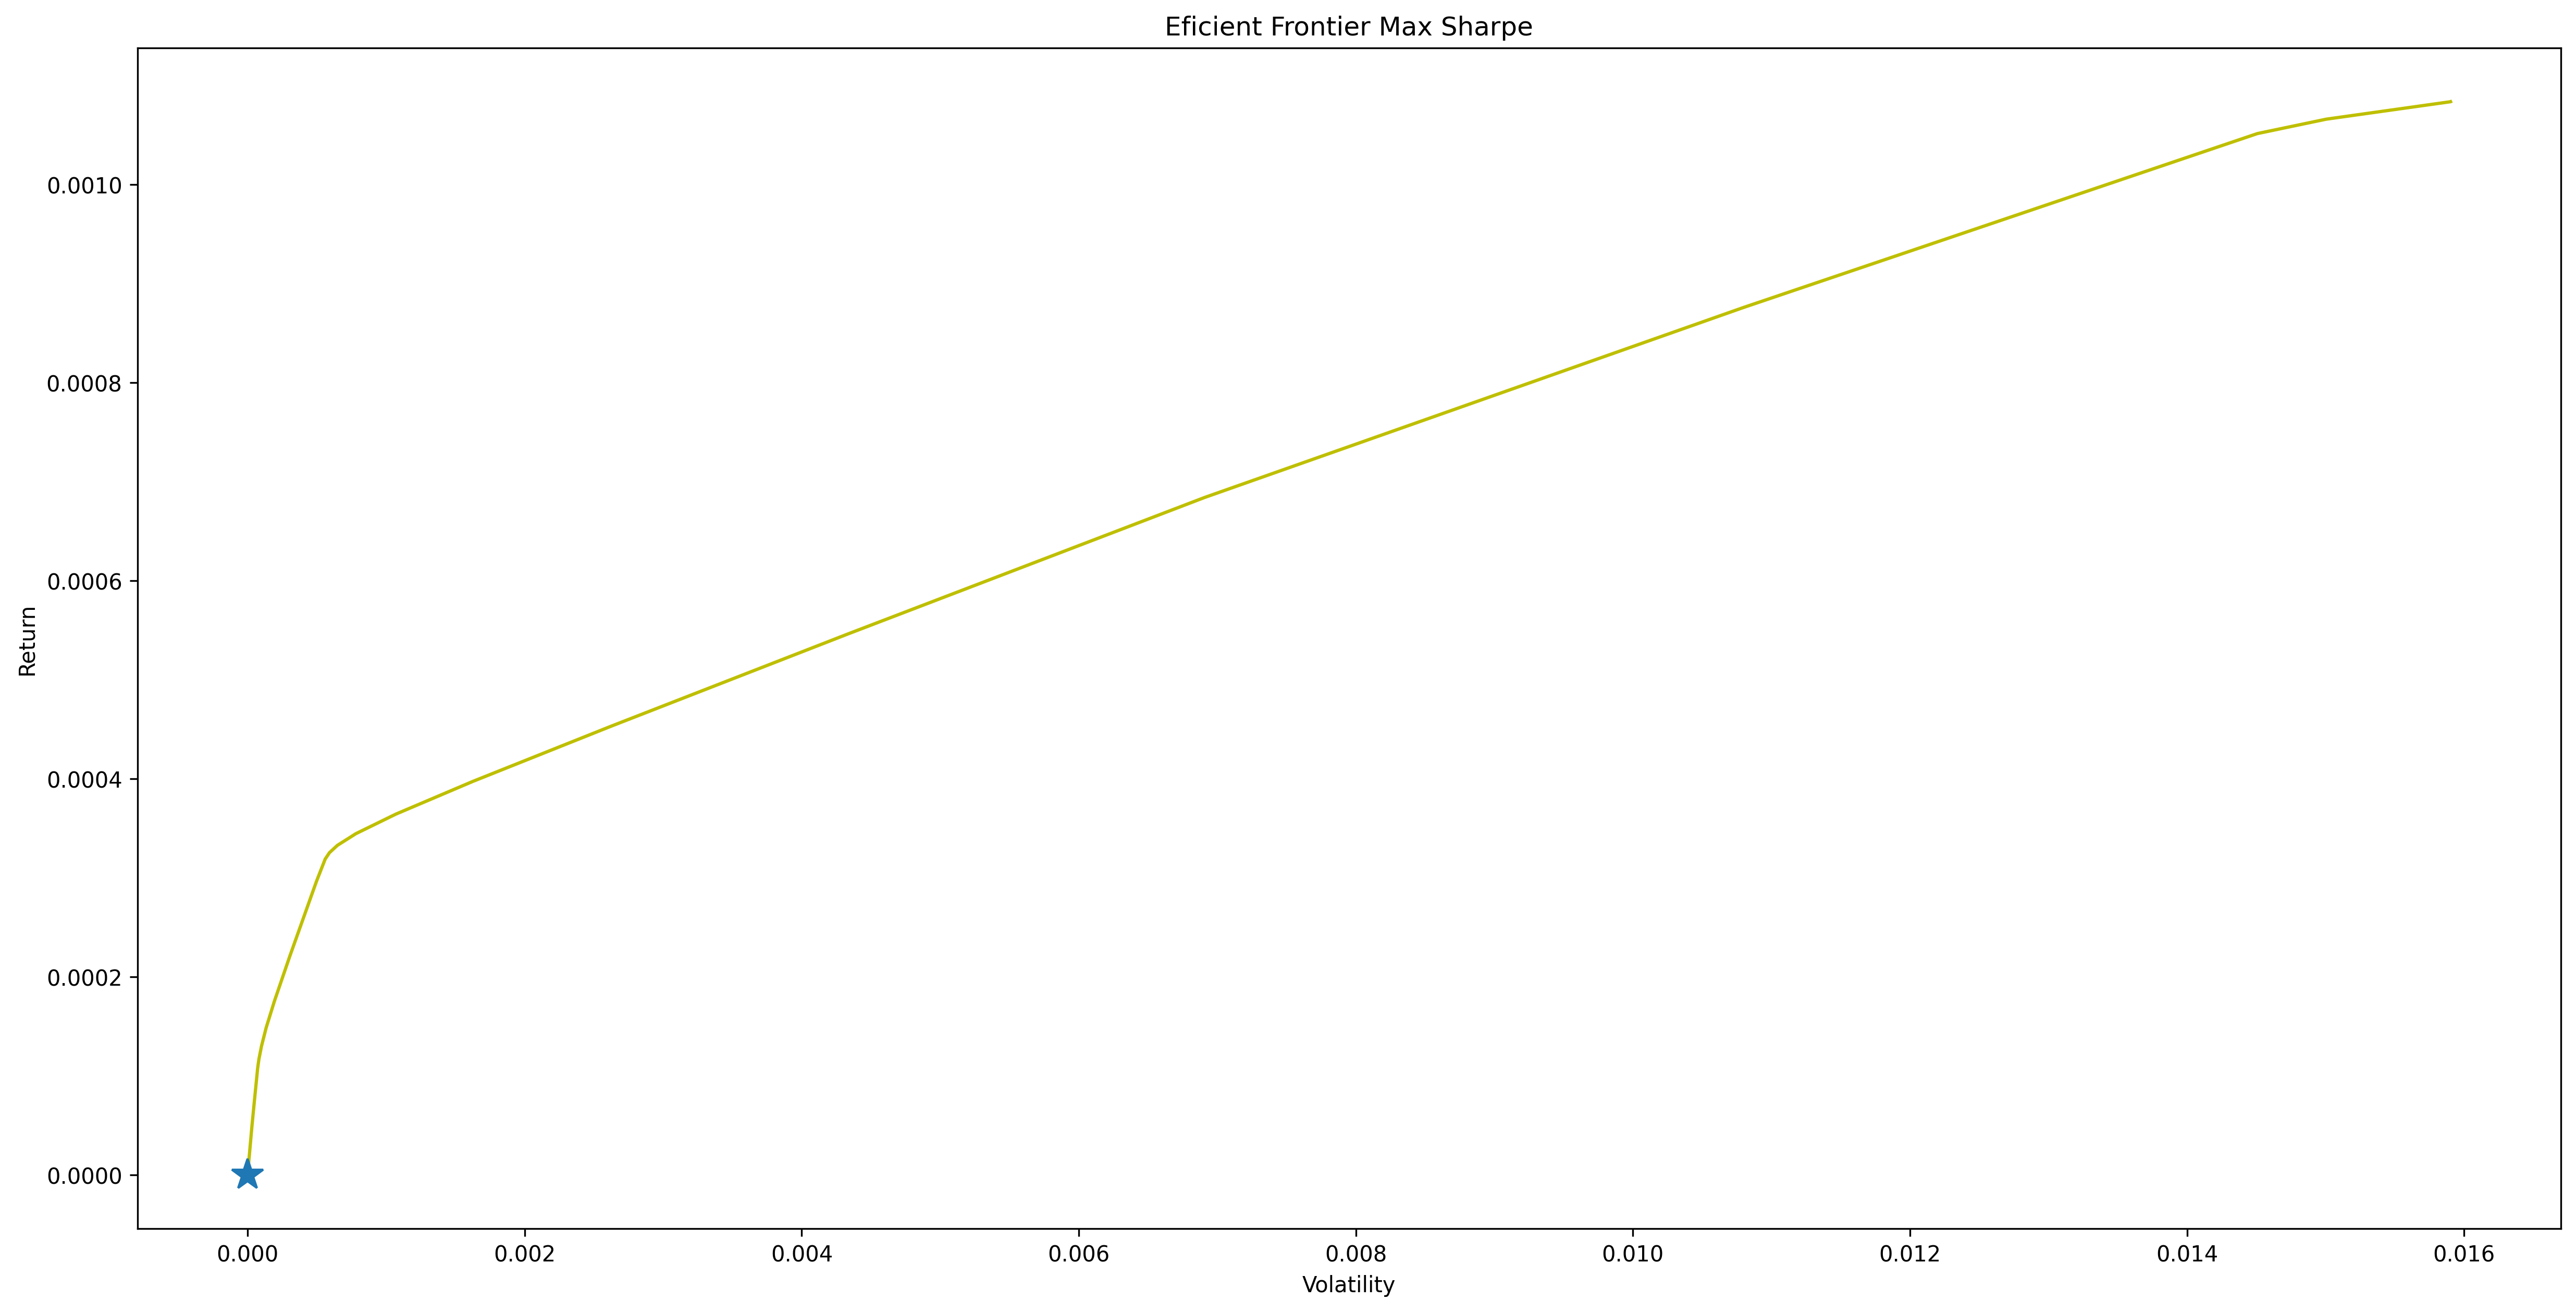

In [20]:
# Plot de la evolucion de la mejor frontera eficiente de cada generacion
ret, risk, _, _ = efficient_frontier(returns.loc[:, list_activos_mejor_frontera[-1]])
_, optimal_ret, optimal_risk, _ = optimal_portfolio(returns.loc[:, list_activos_mejor_frontera[-1]])

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
ax.plot(risk, ret, 'y', label=f'Generacion {idx}')
ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.set_title('Eficient Frontier Max Sharpe')

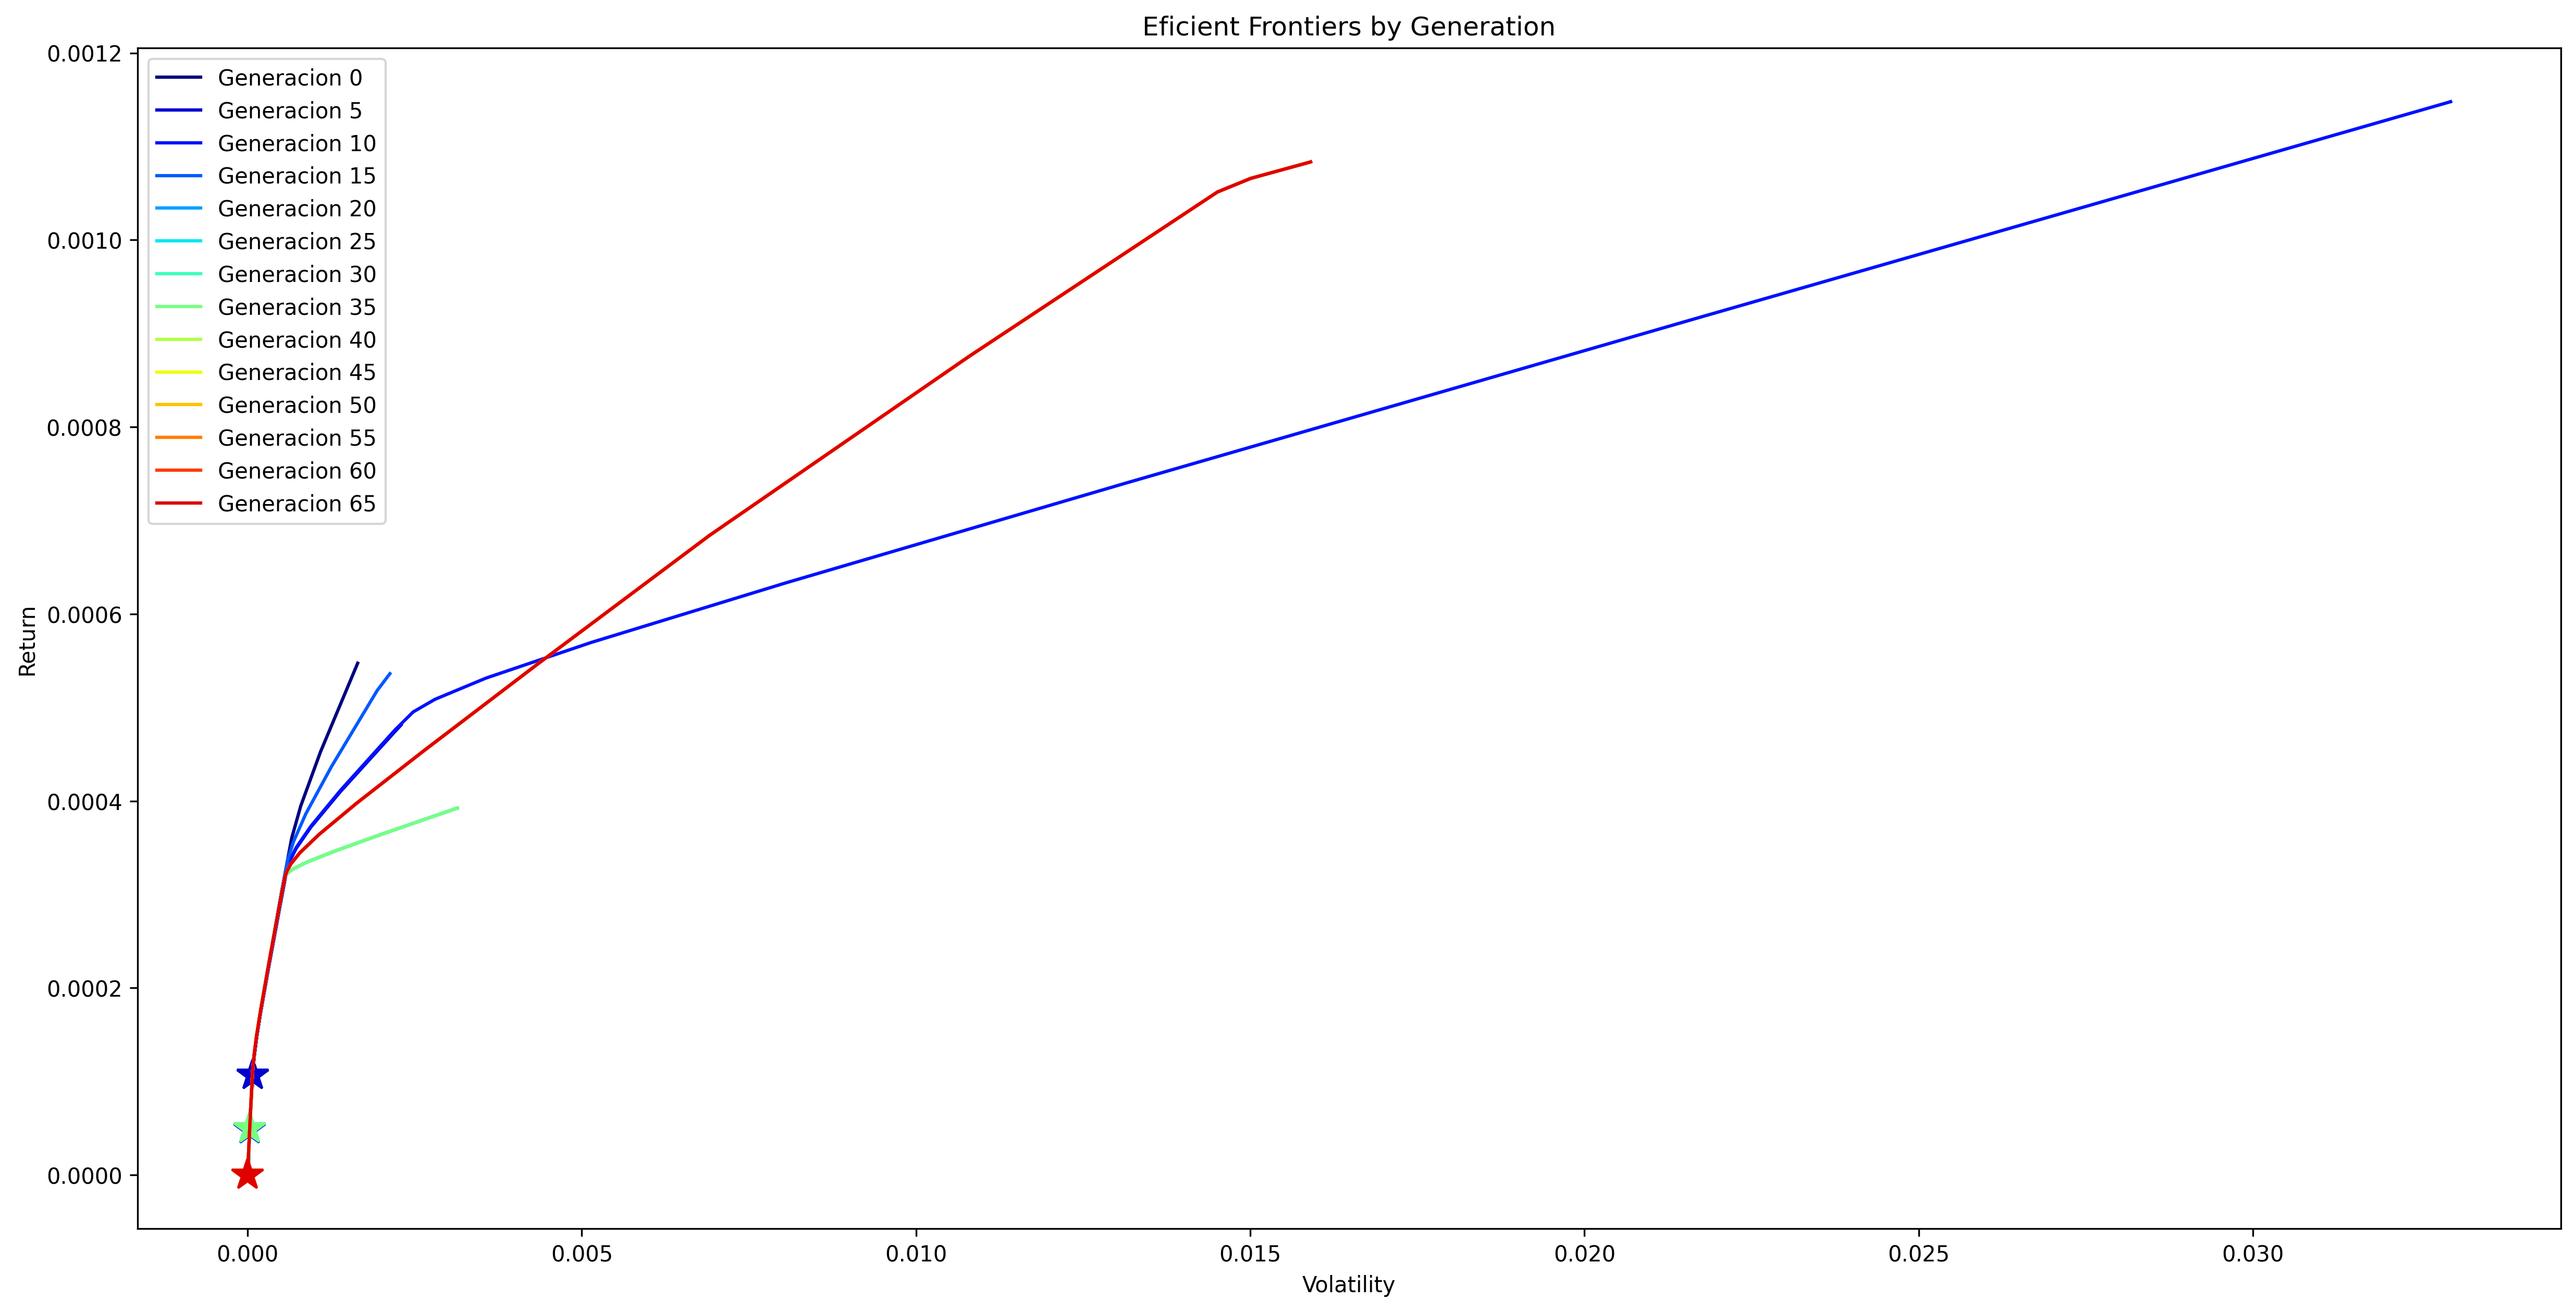

In [21]:
# Plot de la evolucion de la mejor frontera eficiente de cada generacion
list_rets_risks = []
list_optimal_rets_risks = []
for activos, i in zip(list_activos_mejor_frontera, range(0, len(list_activos_mejor_frontera))):
    if i % 5 == 0:
        ret, risk, _, _ = efficient_frontier(returns.loc[:, activos])
        list_rets_risks.append([ret, risk])

        _, optimal_ret, optimal_risk, _ = optimal_portfolio(returns.loc[:, activos])
        list_optimal_rets_risks.append([optimal_ret, optimal_risk])


fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.set_title('Eficient Frontiers by Generation')
idx = 0

for lista, optimals in zip(list_rets_risks, list_optimal_rets_risks):
    ax.plot(lista[1], lista[0], 'y', label=f'Generacion {idx}')
    ax.plot(optimals[1], optimals[0], '*', markersize=15)
    idx += 5


colormap = plt.cm.jet #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 0.95,len(ax.lines))]
for i,j in enumerate(ax.lines):
    if i % 2 == 0:
        j.set_color(colors[i])
    else:
        j.set_color(colors[i-1])

# ax.set_xlim(right=list_rets_risks[-1][1].max())
# ax.set_ylim(top=list_rets_risks[-1][0].max())
plt.legend()
